# 导入库

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pymrmr
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.utils import resample

# 路径

In [2]:
# 输入路径
path_input = r'D:\FJMU_course\Chapter_8\BraTs18\lecture_1'
os.chdir(path_input)
os.getcwd()

# 训练集
X_train = pd.read_csv('transformed_train_data.csv', header=0, index_col=0)
y_train = pd.read_csv('y_train.csv', header=0, index_col=0)

# 测试集
X_test = pd.read_csv('transformed_test_data.csv', header=0, index_col=0)
y_test = pd.read_csv('y_test.csv', header=0, index_col=0)

# 输出路径
path_output = r'D:\FJMU_course\Chapter_8\BraTs18\lecture_3'

# 特征选择

In [3]:
# 方差过滤
var_selector = VarianceThreshold()
var_filtered = var_selector.fit_transform(X_train)
features = var_selector.get_support(indices=True)
var_filtered_df = pd.DataFrame(var_filtered, columns=X_train.columns[features], index=X_train.index)

In [4]:
# mRMR
df = pd.concat([y_train, var_filtered_df],axis=1)
selected_mrmr = pymrmr.mRMR(df, 'MIQ',20)
mRMR_features = var_filtered_df[selected_mrmr]

In [5]:
# RFE
RFC_ = RFC(n_estimators=10,max_depth=3,random_state=42)
selector = RFE(estimator=RFC_, n_features_to_select=8, step=5)
selector.fit(mRMR_features, y_train.values.flatten())

selected_features_mask = selector.support_
selected_features = mRMR_features.columns[selected_features_mask]

X_train_selected = selector.fit_transform(mRMR_features, y_train.values.flatten())
X_test = X_test[mRMR_features.columns]
X_test_selected = selector.transform(X_test)

# 模型构建

In [6]:
# 用选择的特征训练模型
RF_Model = RFC_.fit(X_train_selected, y_train.values.flatten())
RF_Model.score(X_test_selected, y_test.values.flatten())

0.8333333333333334

# 模型评价

## 混淆矩阵

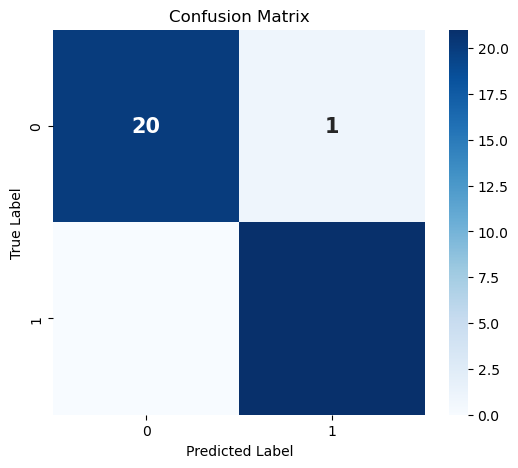

In [7]:
# 训练集、测试集预测结果的array
y_train_pred = RF_Model.predict(X_train_selected)
y_test_pred = RF_Model.predict(X_test_selected)

# 计算混淆矩阵
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel()
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()


# 使用示例数据计算混淆矩阵
confusion = confusion_matrix(y_train, y_train_pred)

# 绘制混淆矩阵
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(confusion, cmap='Blues', annot=True, annot_kws={'size': 15, 'weight': 'bold'}, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 性能度量

In [8]:
# 计算各项指标
sensitivity_train = tp_train / (tp_train + fn_train)
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_train = tn_train / (tn_train + fp_train)
specificity_test = tn_test / (tn_test + fp_test)
ppv_train = tp_train / (tp_train + fp_train)
ppv_test = tp_test / (tp_test + fp_test)
npv_train = tn_train / (tn_train + fn_train)
npv_test = tn_test / (tn_test + fn_test)
youden_train = sensitivity_train + specificity_train - 1
youden_test = sensitivity_test + specificity_test - 1

# 创建字典来存储所有的性能指标
metrics = {
    "Accuracy": (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)),
    "Sensitivity": (sensitivity_train, sensitivity_test),
    "Specificity": (specificity_train, specificity_test),
    "Precision": (precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)),
    "Recall": (recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)),
    "PPV": (ppv_train, ppv_test),
    "NPV": (npv_train, npv_test),
    "F1 Score": (f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)),
    "Youden's Index": (youden_train, youden_test)
}

# 创建DataFrame展示性能指标
metrics_df = pd.DataFrame(metrics, index=["Train", "Test"]).T.round(3)
metrics_df

,Train,Test
Accuracy,0.976,0.833
Sensitivity,1.000,0.889
Specificity,0.952,0.778
Precision,0.955,0.800
Recall,1.000,0.889
PPV,0.955,0.800
NPV,1.000,0.875
F1 Score,0.977,0.842
Youden's Index,0.952,0.667


## ROC曲线

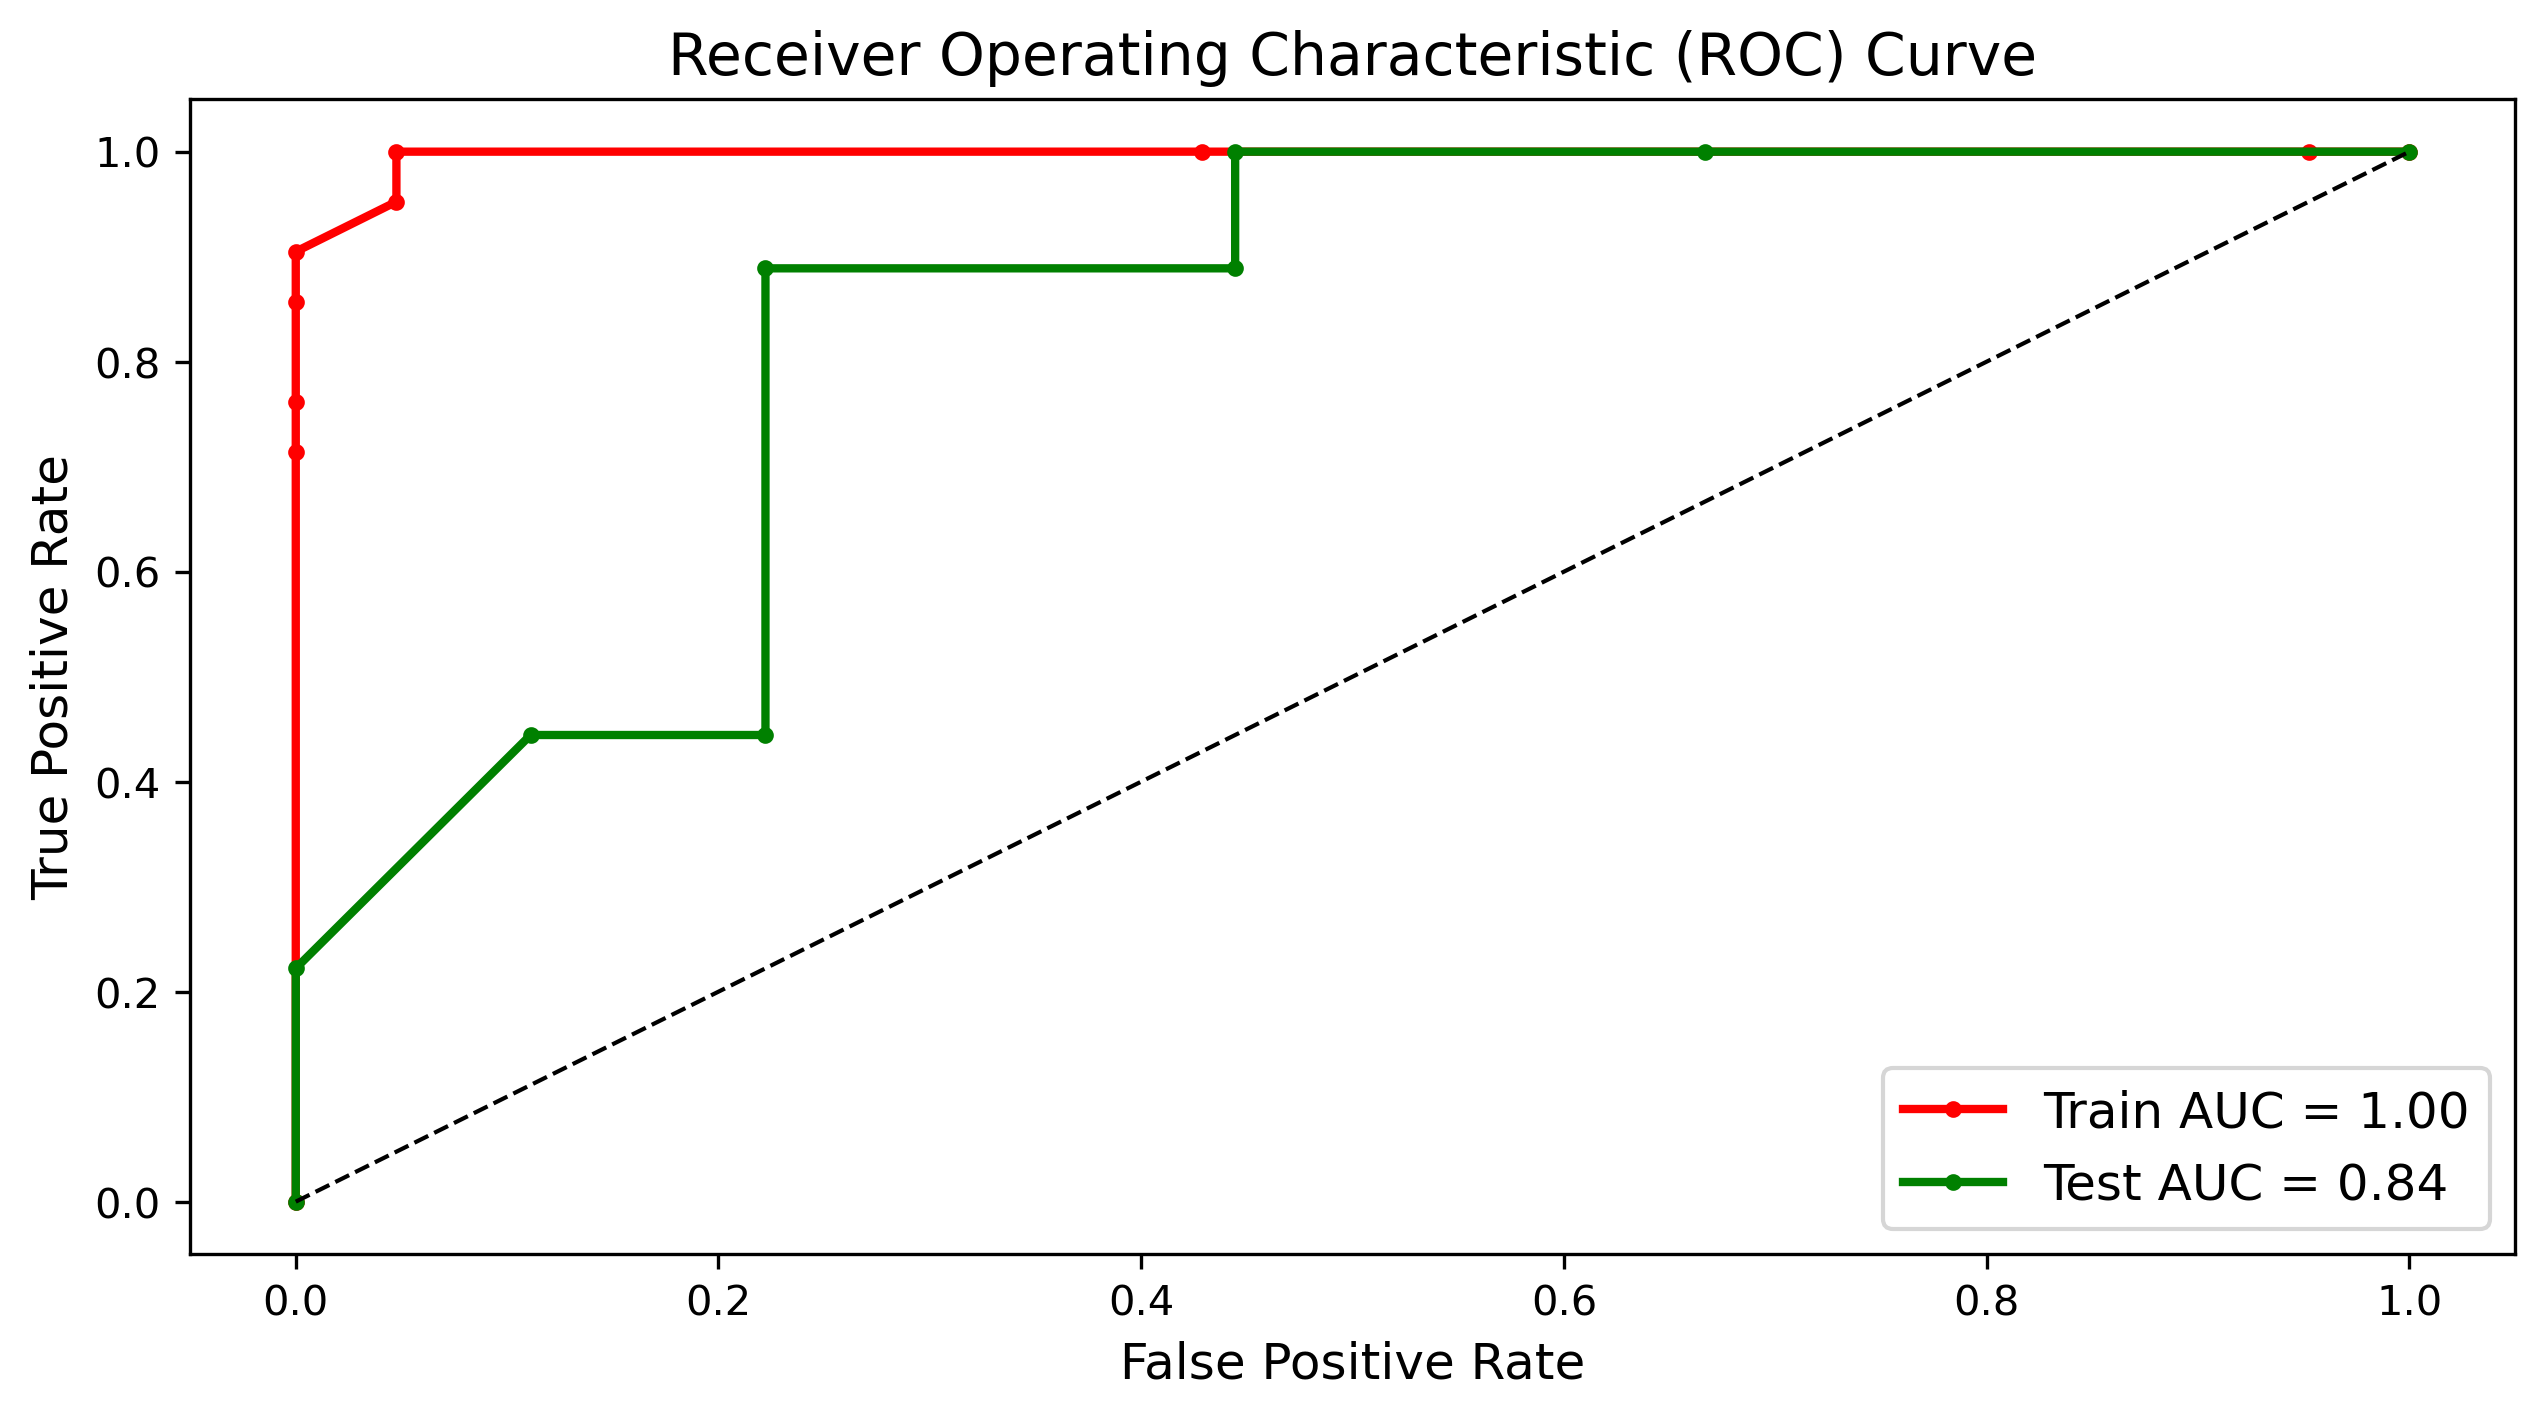

In [9]:
# 获取模型预测为正的概率
y_train_proba = RF_Model.predict_proba(X_train_selected)[:, 1]
y_test_proba = RF_Model.predict_proba(X_test_selected)[:, 1]

# 计算AUC
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# 计算ROC曲线的FPR, TPR, 阈值
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)

# 使用roc_auc_score计算的AUC值
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# 绘制ROC曲线
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc_train:.2f}', color='red', linestyle='-', linewidth=2, marker='.')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc_test:.2f}', color='green', linestyle='-', linewidth=2, marker='.')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(False)
plt.gca().set_facecolor('white')
plt.show()

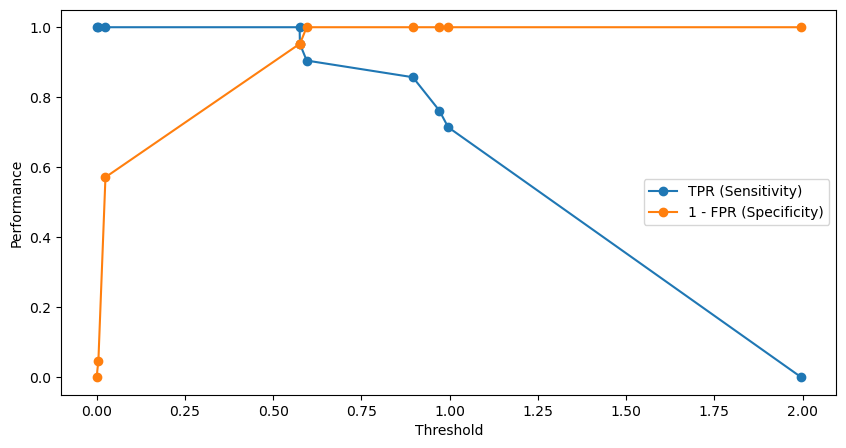

In [10]:
# 交叉阈值可视化
plt.figure(figsize=(10, 5))
plt.plot(thresholds_train, tpr_train, label='TPR (Sensitivity)', linestyle='-', marker='o')
plt.plot(thresholds_train, 1 - fpr_train, label='1 - FPR (Specificity)', linestyle='-', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Performance')
plt.legend()
plt.grid(False)
plt.show()

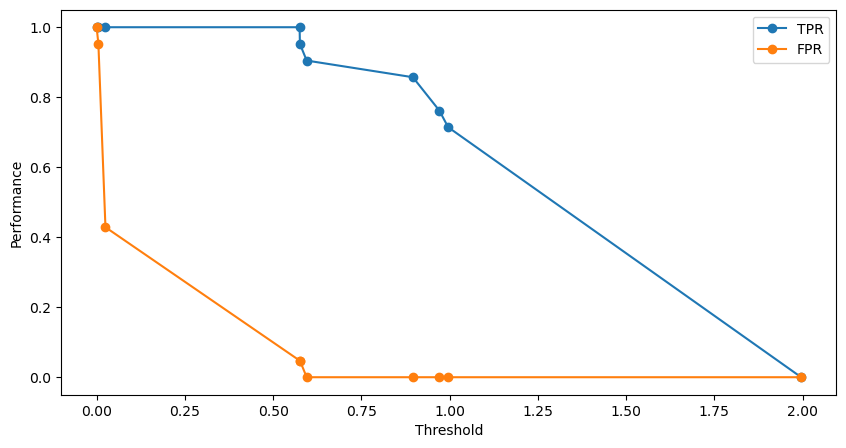

In [11]:
# 约登指数可视化
plt.figure(figsize=(10, 5))
plt.plot(thresholds_train, tpr_train, label='TPR', linestyle='-', marker='o')
plt.plot(thresholds_train, fpr_train, label='FPR', linestyle='-', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Performance')
plt.legend()
plt.grid(False)
plt.show()

In [12]:
# 计算最高的Youden's Index 阈值
J = tpr_train - fpr_train
optimal_idx = np.argmax(J)
optimal_threshold_youden = thresholds_train[optimal_idx]
print(f"optimal threshold youden:{optimal_threshold_youden}")

# 计算交叉阈值
optimal_idx_cross = np.argmin(np.abs(tpr_train - (1 - fpr_train)))
optimal_threshold_cross = thresholds_train[optimal_idx_cross]
print(f"optimal threshold cross:{optimal_threshold_cross}")

optimal threshold youden:0.575
optimal threshold cross:0.5758333333333333


In [13]:
# 应用 Youden's Index 阈值
y_train_pred_youden = (y_train_proba >= optimal_threshold_youden).astype(int)
y_test_pred_youden = (y_test_proba >= optimal_threshold_youden).astype(int)

# 应用交叉阈值
y_train_pred_cross = (y_train_proba >= optimal_threshold_cross).astype(int)
y_test_pred_cross = (y_test_proba >= optimal_threshold_cross).astype(int)

**根据最新阈值重新评估模型效果**

In [14]:
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    youden = sensitivity + specificity - 1
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Precision": precision,
        "Recall": recall,
        "PPV": ppv,
        "NPV": npv,
        "F1 Score": f1,
        "Youden's Index": youden
    }

In [15]:
metrics_default_train = calculate_metrics(y_train, y_train_pred)
metrics_default_test = calculate_metrics(y_test, y_test_pred)
metrics_youden_train = calculate_metrics(y_train, y_train_pred_youden)
metrics_youden_test = calculate_metrics(y_test, y_test_pred_youden)
metrics_cross_train = calculate_metrics(y_train, y_train_pred_cross)
metrics_cross_test = calculate_metrics(y_test, y_test_pred_cross)

metrics_df = pd.DataFrame({
    "Default Train": metrics_default_train,
    "Default Test": metrics_default_test,
    "Youden Train": metrics_youden_train,
    "Youden Test": metrics_youden_test,
    "Cross Train": metrics_cross_train,
    "Cross Test": metrics_cross_test
})


metrics_df = metrics_df.round(3).T
metrics_df

,Accuracy,Sensitivity,Specificity,Precision,Recall,PPV,NPV,F1 Score,Youden's Index
Default Train,0.976,1.000,0.952,0.955,1.000,0.955,1.000,0.977,0.952
Default Test,0.833,0.889,0.778,0.800,0.889,0.800,0.875,0.842,0.667
Youden Train,0.976,1.000,0.952,0.955,1.000,0.955,1.000,0.977,0.952
Youden Test,0.833,0.889,0.778,0.800,0.889,0.800,0.875,0.842,0.667
Cross Train,0.952,0.952,0.952,0.952,0.952,0.952,0.952,0.952,0.905
Cross Test,0.778,0.778,0.778,0.778,0.778,0.778,0.778,0.778,0.556


## 校准曲线

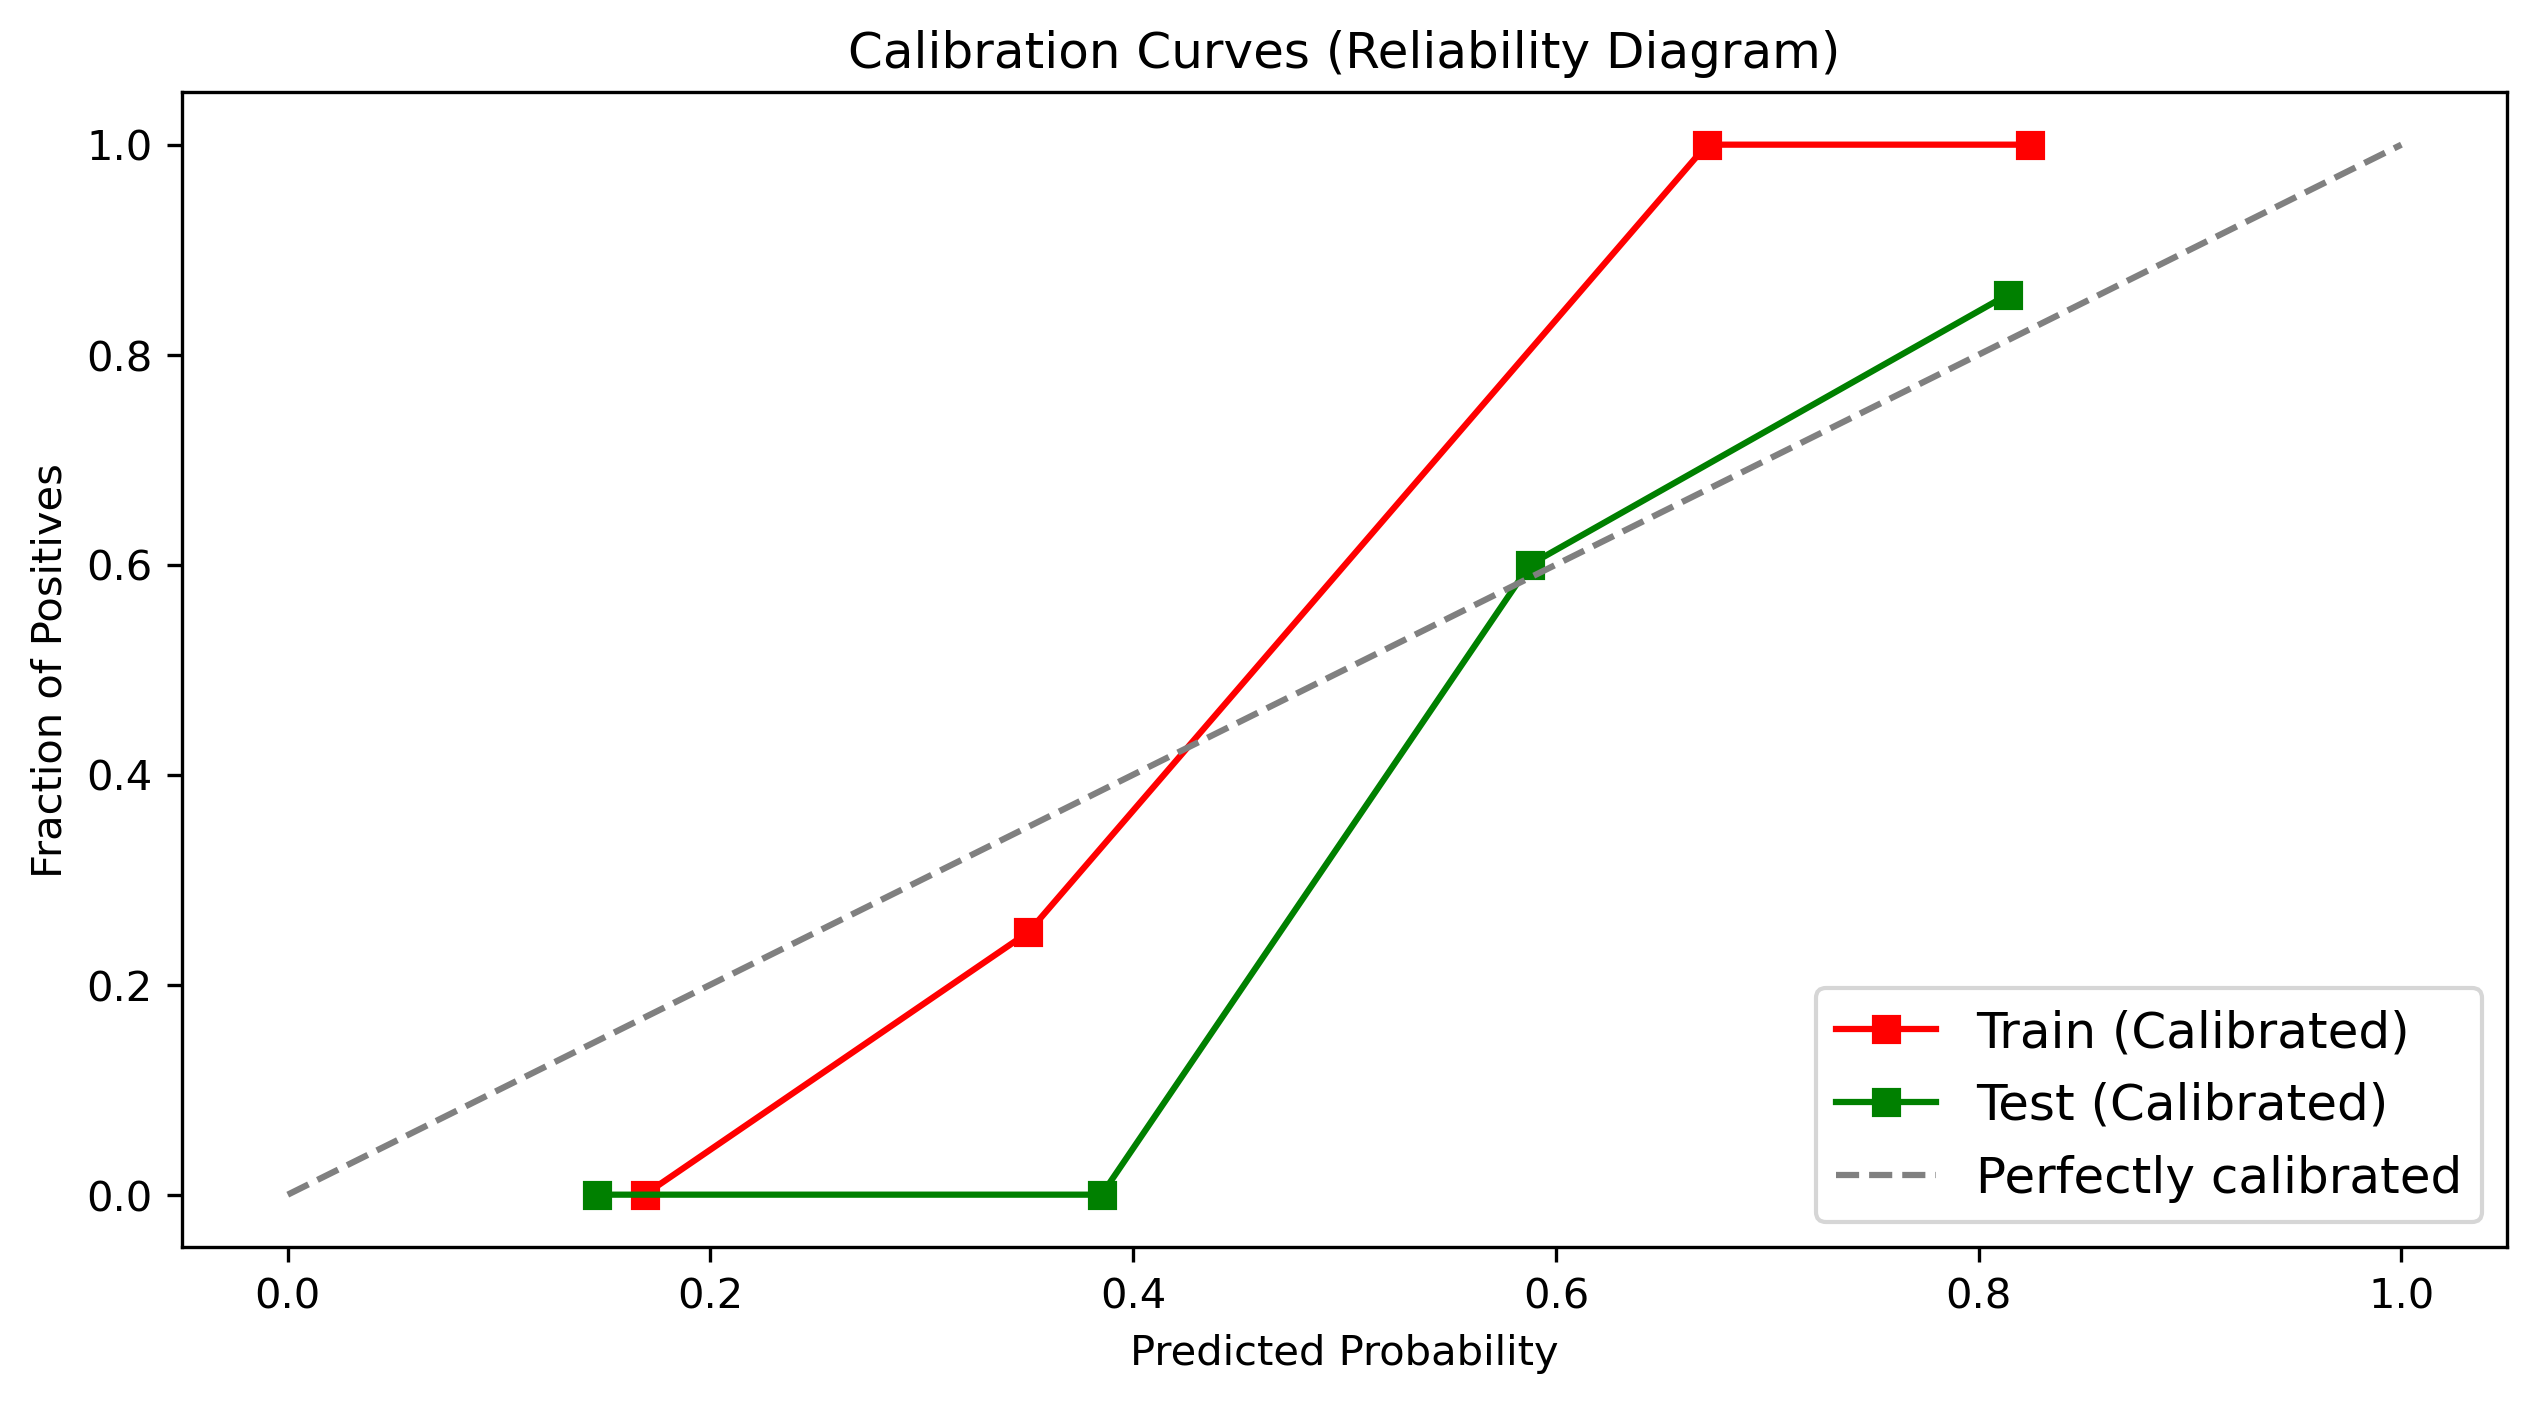

In [16]:
# 假定RF_Model是你训练好的模型实例
# 对模型的预测概率进行校正
calibrated_model = CalibratedClassifierCV(estimator=RF_Model, method='sigmoid', cv=5)
calibrated_model.fit(mRMR_features, y_train.values.flatten())  # 通过交叉验证矫正
# 获取校正后的概率
y_train_pred_calibrated = calibrated_model.predict_proba(mRMR_features)[:, 1]
y_test_pred_calibrated = calibrated_model.predict_proba(X_test[mRMR_features.columns])[:, 1]


# 校准曲线：表观和校正后
prob_true_train_calibrated, prob_pred_train_calibrated = calibration_curve(y_train, y_train_pred_calibrated, n_bins=4)
prob_true_test_calibrated, prob_pred_test_calibrated = calibration_curve(y_test, y_test_pred_calibrated, n_bins=4)

# 绘制校准曲线
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(prob_pred_train_calibrated, prob_true_train_calibrated, 's-', label='Train (Calibrated)',color='red')
plt.plot(prob_pred_test_calibrated, prob_true_test_calibrated, 's-', label='Test (Calibrated)',color='green')
plt.plot([0, 1], [0, 1], '--', label='Perfectly calibrated',color='grey')
plt.xlabel('Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curves (Reliability Diagram)')
plt.legend(loc='lower right', fontsize=12)
plt.show()

## 临床决策曲线

In [17]:
# https://blog.csdn.net/qq_48321729/article/details/123241746

def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model


def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all


def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all):
    #Plot
    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Model')
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    #Fill，显示出模型较于treat all和treat none好的部分
    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)

    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,1)
    ax.set_ylim(-0.05, net_benefit_model.max() + 0.05)
#     ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right')

    return ax

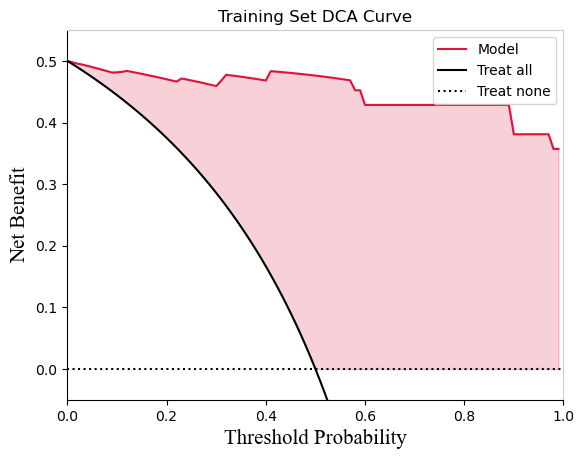

In [18]:
if __name__ == '__main__':
    # 使用模型对测试集进行概率预测
    y_pred_prob = RF_Model.predict_proba(X_train_selected)[:, 1]

    # 定义阈值组
    thresh_group = np.arange(0, 1, 0.01)
    
    # 计算决策曲线
    net_benefit_model = calculate_net_benefit_model(thresh_group, y_pred_prob, y_train.values.flatten())
    net_benefit_all = calculate_net_benefit_all(thresh_group, y_train.values.flatten())
    
    # 绘制决策曲线
    fig, ax = plt.subplots()
    plt.title('Training Set DCA Curve')
    plt.gca().set_facecolor('white')
    ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all)
    plt.grid(False)
    plt.show()

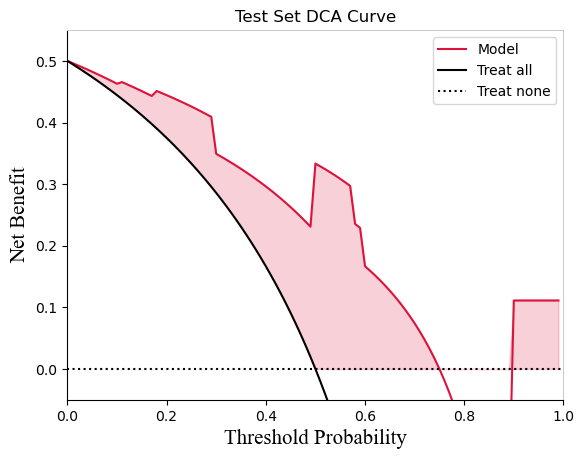

In [19]:
if __name__ == '__main__':
    # 使用模型对测试集进行概率预测
    y_pred_prob = RF_Model.predict_proba(X_test_selected)[:, 1]

    # 定义阈值组
    thresh_group = np.arange(0, 1, 0.01)
    
    # 计算决策曲线
    net_benefit_model = calculate_net_benefit_model(thresh_group, y_pred_prob, y_test.values.flatten())
    net_benefit_all = calculate_net_benefit_all(thresh_group, y_test.values.flatten())
    
    # 绘制决策曲线
    fig, ax = plt.subplots()
    plt.title('Test Set DCA Curve')
    plt.gca().set_facecolor('white')
    ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all)
    plt.grid(False)
    plt.show()